# Titanic - Predicting Survival
### By Nico Hertel
mail@nicohertel.de

##### Problem Description (from https://www.kaggle.com/c/titanic)
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

##### Evaluation
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each PassengerId in the test set, you must predict a 0 or 1 value for the Survived variable.

Your score is the percentage of passengers you correctly predict. This is known simply as "accuracy”.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV

In [32]:
% matplotlib inline

sns.set_style('darkgrid')
sns.set_palette("husl")

### Data Exploration

In [113]:
data = pd.read_csv('titanic_train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have categorical and numerical data:
    - Categorical: Name, Sex, Ticket, Cabin and Embarked
    - Numerical: ID, Survied, Pclass, Age, SibSP, Parch, Fare

Also, the cabin-information is missing in most (77%) cases

Ticket information is numeric or alphanumeric, Cabin is alphanumeric -> Translate into numeric values?

Embarked is encoding the port of Embarkation, C=Cherbourg, Q=Queenstown, S=Southampton
-> Embarked and Sex can be hot encoded

In [59]:
print('%.2f%% of passangers in the trainign data survived, compared to ~32%% of all passangers' %(100*np.mean(data['Survived'])))
print('%.2f%% of passangers traveled without children/parents' %(100*np.sum(data['Parch']==0)/len(data['Parch'])))
print('%.2f%% of passangers traveled without siblings/spouses' %(100*np.sum(data['SibSp']==0)/len(data['SibSp'])))
print('%.2f%% of passangers were male' %(100*np.sum(data['Sex']=='male')/len(data['Sex'])))

38.38% of passangers in the trainign data survived, compared to ~32% of all passangers
76.09% of passangers traveled without children/parents
68.24% of passangers traveled without siblings/spouses
64.76% of passangers were male


In [40]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [60]:
data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### Results of Data Exploration

#### Observations
- Age is missing a big amount of data -> Fill gaps
 - Set gap to mean age
 - Predict age
- Many doublicates in ticket (681/891=0.76 unique entries) -> if no correlation with surviaval, drop
- Cabin has very few entries -> maybe drop, but probably correlated to survival (position on the ship)
- PassengerID is not relevant for survival
- Name has no distinct pattern, maybe able to extract more information, else drop

#### Ideas
- Extract Title from Name -> maybe correlated with survival and/or passenger class
- Combine Number of Siblings, Spouses, Parents and Children into one family-parameter

#### Hypotheses
- Females are more likely to survive than male
- Children are more likely to survive than adults (Till what age?)
- Upper-Class passengers are more likely to survive than others

### Check Hypotheses

In [71]:
data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


#### Females are more likely to survive than male
True, 74% of females survived, but only 19% of males

In [72]:
data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### Upper-Class passengers are more likely to survive than others
True, 63% of First-Class passengers survived, while only 47% of Second-Class and 24% of Third-Class passengers survived

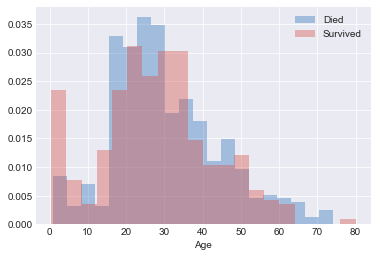

In [89]:
sns.distplot(data[data['Survived'] == 0]['Age'].dropna(), kde=False, label='Died',
             norm_hist=True, bins=20, color=sns.xkcd_rgb["windows blue"])
sns.distplot(data[data['Survived'] == 1]['Age'].dropna(), kde=False, label='Survived',
             norm_hist=True, bins=20, color=sns.xkcd_rgb["pale red"])
plt.legend()
plt.show()

#### Children are more likely to survive than adults (Till what age?)
Seems to be true, especially for babys, but in general till apox 14 years 

### More Data Exploration

#### Check Influence of Embark

In [90]:
data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


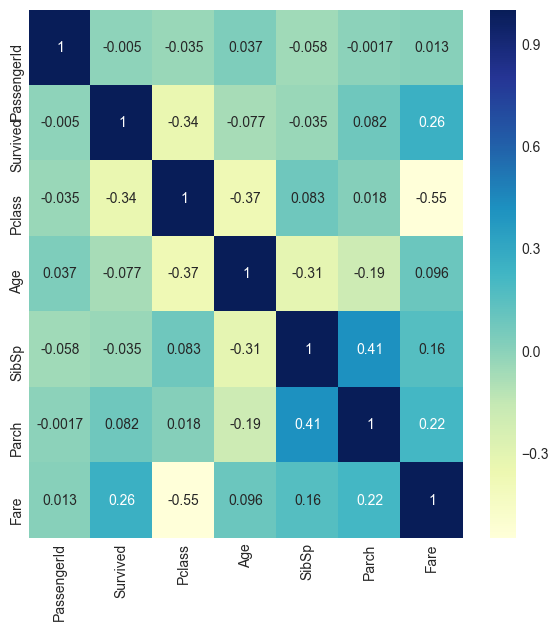

In [106]:
plt.figure(figsize=(7,7), dpi=100)
correlation = data.corr()
sns.heatmap(correlation, cmap='YlGnBu', annot=True)
plt.show()

In [108]:
correlation['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

- Ticket Price and Passenger Class highly correlated with survival
- Age slightly correlated with survival
- PassengerID not correlated with survival

### Modify Data

- Translate categorical into numerical data
- Remove cabin, name PassengerID and ticket information

In [127]:
for key in ['Ticket', 'Name', 'Cabin', 'PassengerId']:
    if key in data.columns:
        data.drop([key], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [128]:
data_clean = pd.get_dummies(data, drop_first=True)
data_clean.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


#### Calculate Correlation including categorical data

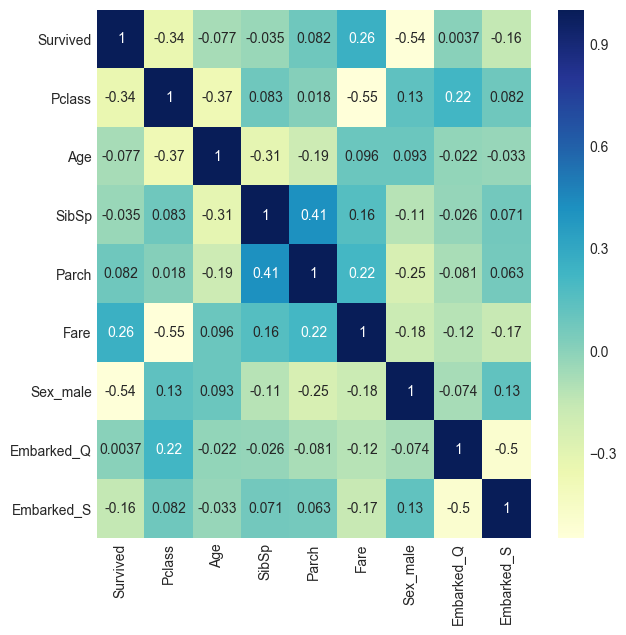

In [129]:
correlation_cat = data_clean.corr()
plt.figure(figsize=(7,7), dpi=100)
correlation = data.corr()
sns.heatmap(correlation_cat, cmap='YlGnBu', annot=True)
plt.show()

In [130]:
correlation_cat['Survived']

Survived      1.000000
Pclass       -0.338481
Age          -0.077221
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.155660
Name: Survived, dtype: float64

### Estimating missing age values
Age is slightly gaussian distributed:
$$\mu_{age}=29.7$$, $$\sigma_{age}=14.5$$
Idea: Using subsets of age with corresponding class and sex values to generate random values for missing age-values, so:
$$Age(sex=male, class=1) \sim \mathcal{N}(\mu_{male,1}, \sigma_{male,1})$$
with $$\mu_{sex, class}$$ and $$\sigma_{sex, class}$$ describing the mean and standard deviation of age for this sex and class

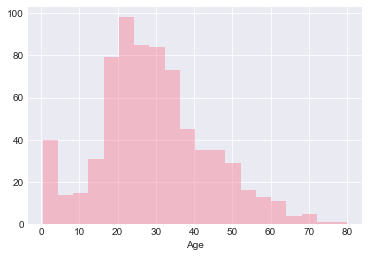

In [148]:
sns.distplot(data_clean['Age'].dropna(), kde=False)
plt.show()

In [161]:
male_c1 = data[(data['Sex']=='male') & (data['Pclass']==1)]['Age']
male_c2 = data[(data['Sex']=='male') & (data['Pclass']==2)]['Age']
male_c3 = data[(data['Sex']=='male') & (data['Pclass']==3)]['Age']
female_c1 = data[(data['Sex']=='female') & (data['Pclass']==1)]['Age']
female_c2 = data[(data['Sex']=='female') & (data['Pclass']==2)]['Age']
female_c3 = data[(data['Sex']=='female') & (data['Pclass']==3)]['Age']

mean_male_c1 = np.mean(male_c1.dropna())
std_male_c1 = np.std(male_c1.dropna())
mean_male_c2 = np.mean(male_c2.dropna())
std_male_c2 = np.std(male_c2.dropna())
mean_male_c3 = np.mean(male_c3.dropna())
std_male_c3 = np.std(male_c3.dropna())

mean_female_c1 = np.mean(female_c1.dropna())
std_female_c1 = np.std(female_c1.dropna())
mean_female_c2 = np.mean(female_c2.dropna())
std_female_c2 = np.std(female_c2.dropna())
mean_female_c3 = np.mean(female_c3.dropna())
std_female_c3 = np.std(female_c3.dropna())

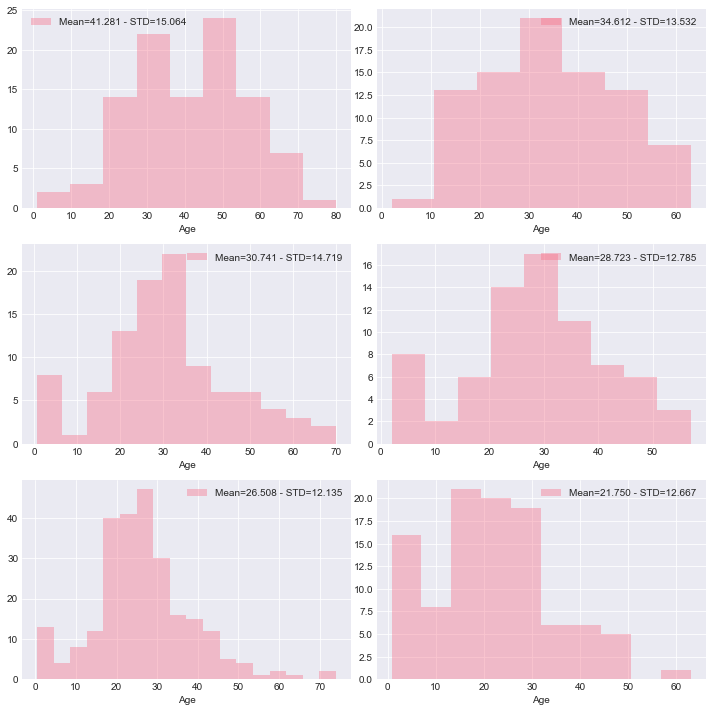

In [185]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
sns.distplot(male_c1.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_male_c1, std_male_c1), kde=False, ax=ax[0][0])
ax[0][0].legend()
sns.distplot(male_c2.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_male_c2, std_male_c2), kde=False, ax=ax[1][0])
ax[1][0].legend()
sns.distplot(male_c3.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_male_c3, std_male_c3), kde=False, ax=ax[2][0])
ax[2][0].legend()
sns.distplot(female_c1.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_female_c1, std_female_c1), kde=False, ax=ax[0][1])
ax[0][1].legend()
sns.distplot(female_c2.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_female_c2, std_female_c2), kde=False, ax=ax[1][1])
ax[1][1].legend()
sns.distplot(female_c3.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_female_c3, std_female_c3), kde=False, ax=ax[2][1])
ax[2][1].legend()


plt.tight_layout()
plt.show()

In [198]:
def replace_age(data, sex, Pclass, mean, std):
    '''
    Replaces all nan-values for age in data with corresponding sex and Pclass with random values,
    taken from a gaussian distribution with parameters mean and std

    Parameters
    ----------
    data : DataFrame
    sex : string ('male' or 'female')
    Pclass : int (1, 2 or 3)
    mean : float
    std : float

    Output
    ------
    data : DataFrame
    '''
    
sex = 'male'
Pclass = 1
data[(data['Sex']==sex) & (data['Pclass']==Pclass)]['Age'].isnull()

6      False
23     False
27     False
30     False
34     False
35     False
54     False
55      True
62     False
64      True
83     False
92     False
96     False
97     False
102    False
110    False
118    False
124    False
137    False
139    False
155    False
168     True
170    False
174    False
185     True
187    False
209    False
224    False
245    False
248    False
       ...  
662    False
671    False
679    False
681    False
690    False
694    False
698    False
701    False
707    False
711     True
712    False
724    False
737    False
740     True
741    False
745    False
748    False
766     True
782    False
789    False
793     True
802    False
806    False
815     True
822    False
839     True
857    False
867    False
872    False
889    False
Name: Age, Length: 122, dtype: bool